# Movie Rating Prediction

Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

Reading .dat Files

In [2]:
# Read 'movies.dat' file
movies_data = pd.read_csv('movies.dat', sep='::', engine='python', encoding='ISO-8859-1', header=None)
movies_data.columns = ['MovieID', 'Title', 'Genre']

# Read 'ratings.dat' file
ratings_data = pd.read_csv('ratings.dat', sep='::', engine='python',encoding='ascii', header=None)
ratings_data.columns = ['UserID', 'MovieID', 'Ratings', 'TimeStamp']

# Read 'users.dat' file
users_data = pd.read_csv('users.dat', sep='::', engine='python',encoding='ascii', header=None)
users_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']


Display the first few rows of the dataset

In [3]:
movies_data.head()

,MovieID,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


 Get an overview of the dataset

In [4]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genre    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


Check summary statistics

In [5]:
movies_data.describe()

,MovieID
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


Count the occurrences of each genre

In [6]:
genre_counts = movies_data['Genre'].str.split('|', expand=True).stack().value_counts()

Plot a bar chart of genre counts


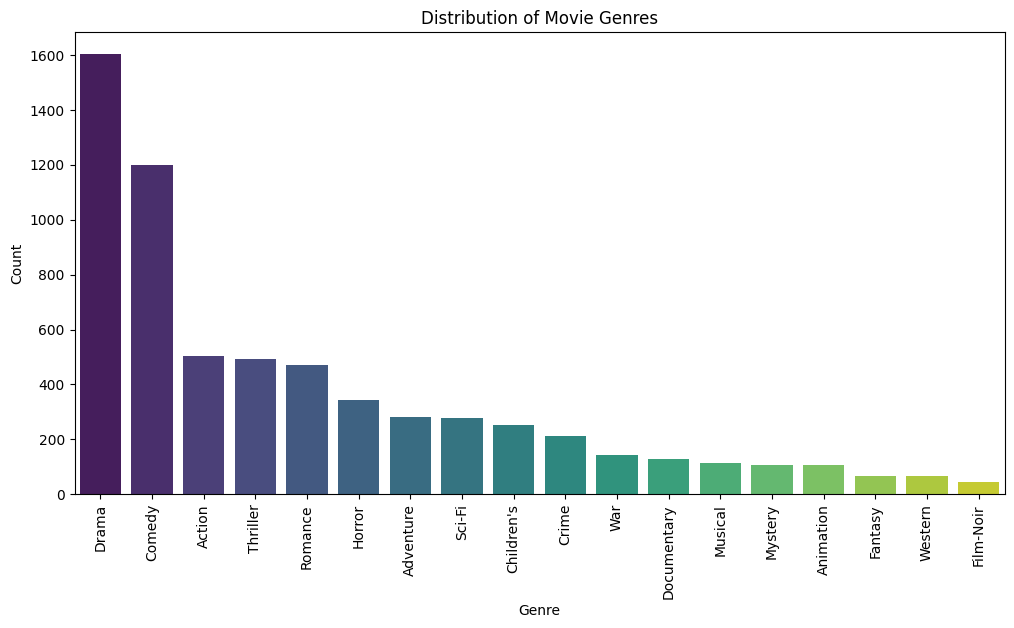

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Movie Genres')
plt.show()

Calculate the length of each movie title

In [8]:
movies_data['Title_Length'] = movies_data['Title'].apply(lambda x: len(x))

Plot a histogram of title lengths


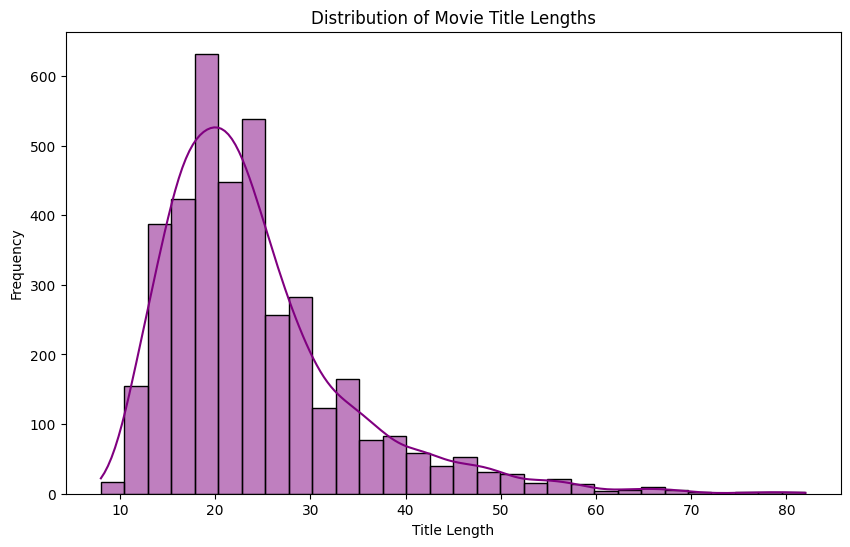

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=movies_data, x='Title_Length', kde=True, bins=30, color='purple')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Title Lengths')
plt.show()


Extract the year from the title using regular expressions


In [10]:
movies_data['Year'] = movies_data['Title'].str.extract(r'\((\d{4})\)$')

Count the number of movies in each year


In [11]:
year_counts = movies_data['Year'].value_counts()

Plot a line chart of movie counts by year

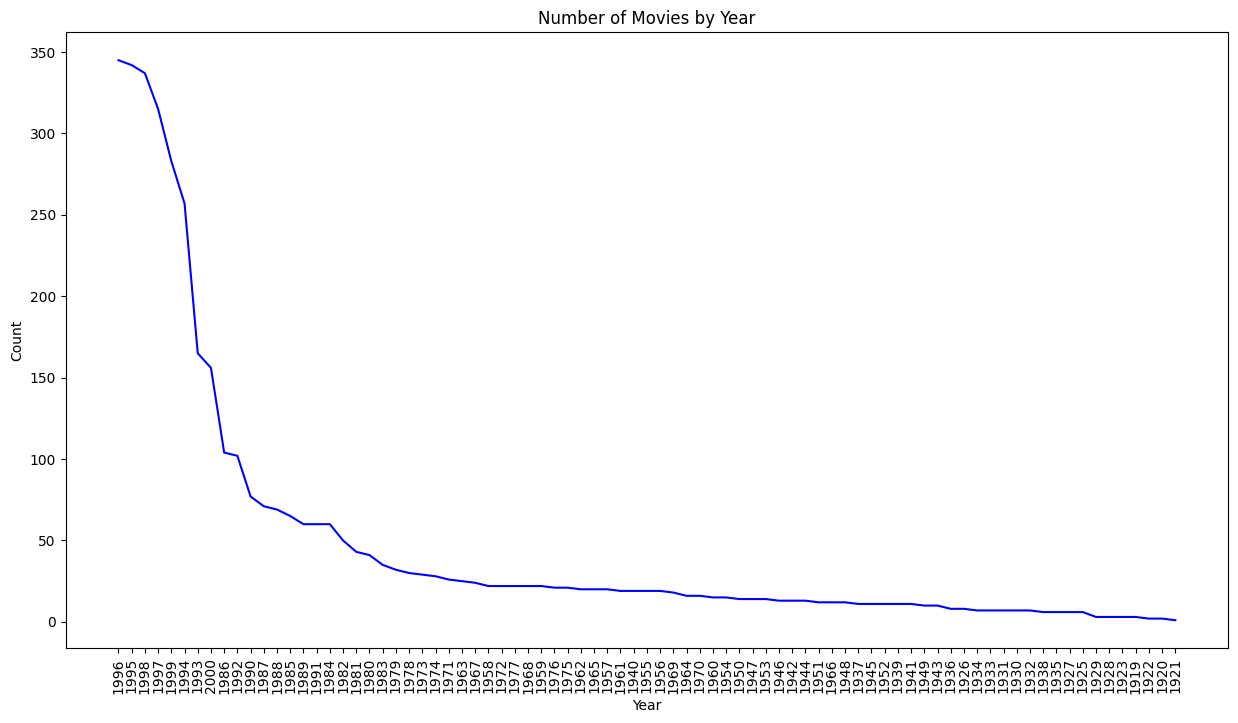

In [12]:
plt.figure(figsize=(15, 8))
sns.lineplot(x=year_counts.index, y=year_counts.values, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Movies by Year')
plt.show()

Check for null values in the dataset


In [13]:
null_values = movies_data.isnull().sum()

# Print the count of null values for each column
print(null_values)


MovieID         0
Title           0
Genre           0
Title_Length    0
Year            0
dtype: int64


Remove the date from the 'Title' column


In [14]:
movies_data['Title'] = movies_data['Title'].apply(lambda x: re.sub(r'\(\d{4}\)$', '', x.strip()))

Display the updated dataset


In [15]:
movies_data.head(10)

,MovieID,Title,Genre,Title_Length,Year
0,1,Toy Story,Animation|Children's|Comedy,16,1995
1,2,Jumanji,Adventure|Children's|Fantasy,14,1995
2,3,Grumpier Old Men,Comedy|Romance,23,1995
3,4,Waiting to Exhale,Comedy|Drama,24,1995
4,5,Father of the Bride Part II,Comedy,34,1995
5,6,Heat,Action|Crime|Thriller,11,1995
6,7,Sabrina,Comedy|Romance,14,1995
7,8,Tom and Huck,Adventure|Children's,19,1995
8,9,Sudden Death,Action,19,1995
9,10,GoldenEye,Action|Adventure|Thriller,16,1995


In [16]:
# Display the first few rows of the dataset
print(ratings_data.head())

   UserID  MovieID  Ratings  TimeStamp
0       1     1193        5  978300760
1       1      661        3  978302109
2       1      914        3  978301968
3       1     3408        4  978300275
4       1     2355        5  978824291


Get an overview of the dataset


In [17]:
print(ratings_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Ratings    1000209 non-null  int64
 3   TimeStamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
None


Check summary statistics


In [18]:
print(ratings_data.describe())

             UserID       MovieID       Ratings     TimeStamp
count  1.000209e+06  1.000209e+06  1.000209e+06  1.000209e+06
mean   3.024512e+03  1.865540e+03  3.581564e+00  9.722437e+08
std    1.728413e+03  1.096041e+03  1.117102e+00  1.215256e+07
min    1.000000e+00  1.000000e+00  1.000000e+00  9.567039e+08
25%    1.506000e+03  1.030000e+03  3.000000e+00  9.653026e+08
50%    3.070000e+03  1.835000e+03  4.000000e+00  9.730180e+08
75%    4.476000e+03  2.770000e+03  4.000000e+00  9.752209e+08
max    6.040000e+03  3.952000e+03  5.000000e+00  1.046455e+09


Visualize the distribution of ratings


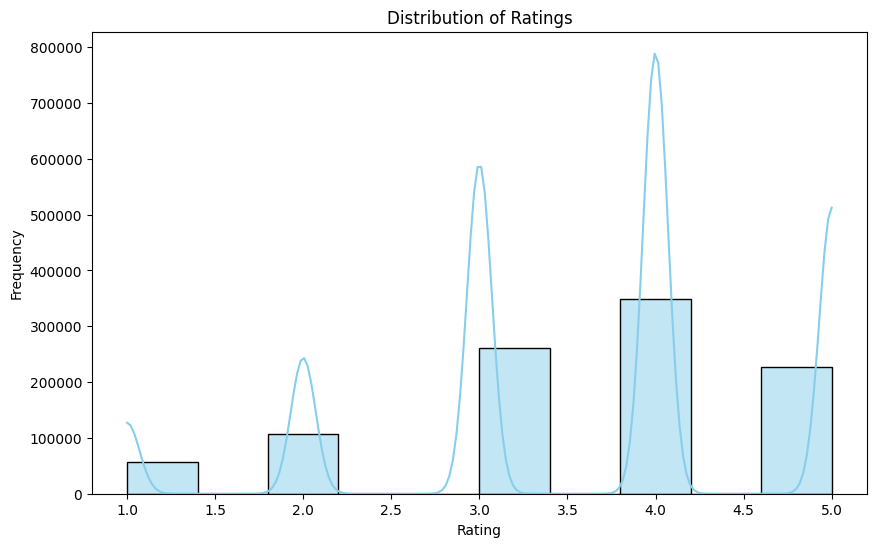

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings_data, x='Ratings', kde=True, bins=10, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

Visualize the number of ratings per user


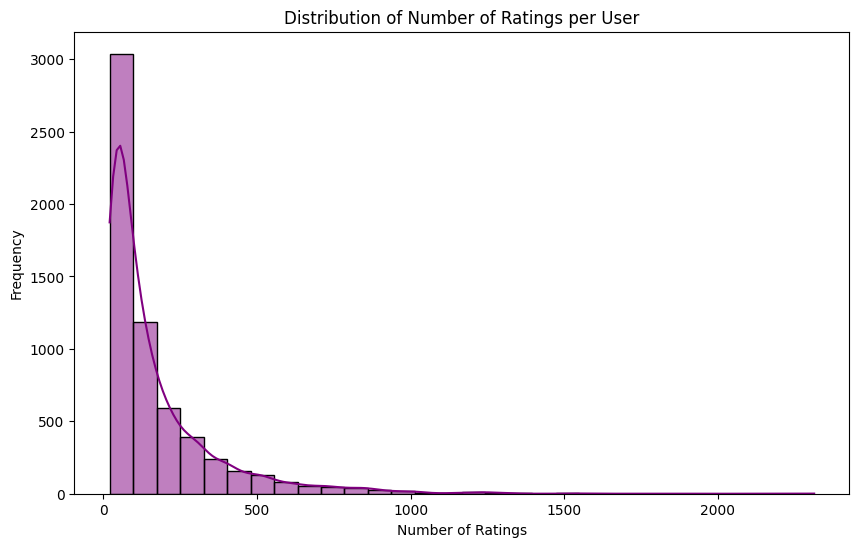

In [20]:
user_ratings_count = ratings_data['UserID'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(data=user_ratings_count, x=user_ratings_count, kde=True, bins=30, color='purple')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Ratings per User')
plt.show()

Visualize the number of ratings per movie


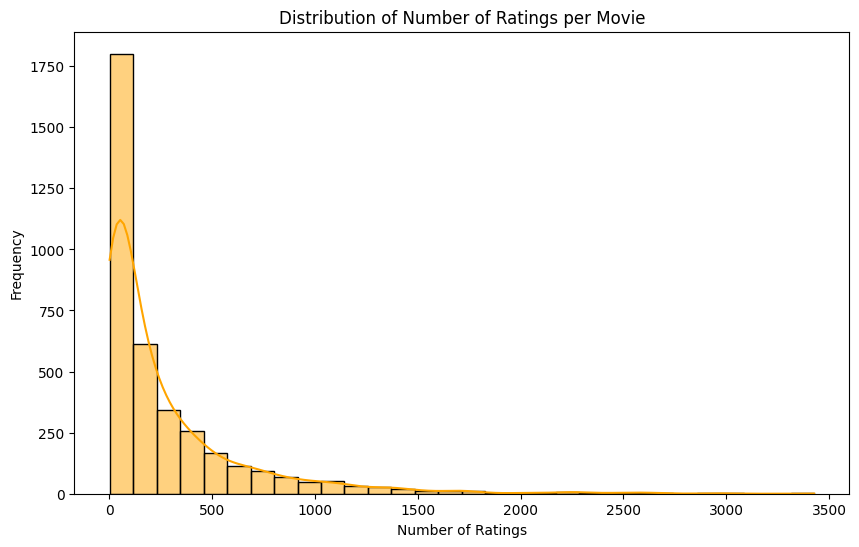

In [21]:
movie_ratings_count = ratings_data['MovieID'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(data=movie_ratings_count, x=movie_ratings_count, kde=True, bins=30, color='orange')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Ratings per Movie')
plt.show()

Check for null values


In [22]:
print(ratings_data.isnull().sum())

UserID       0
MovieID      0
Ratings      0
TimeStamp    0
dtype: int64


Display the first few rows of the dataset


In [23]:
print(users_data.head())

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


Get an overview of the dataset


In [24]:
print(users_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None


Check summary statistics


In [25]:
print(users_data.describe())

            UserID          Age   Occupation
count  6040.000000  6040.000000  6040.000000
mean   3020.500000    30.639238     8.146854
std    1743.742145    12.895962     6.329511
min       1.000000     1.000000     0.000000
25%    1510.750000    25.000000     3.000000
50%    3020.500000    25.000000     7.000000
75%    4530.250000    35.000000    14.000000
max    6040.000000    56.000000    20.000000


Visualize the distribution of age


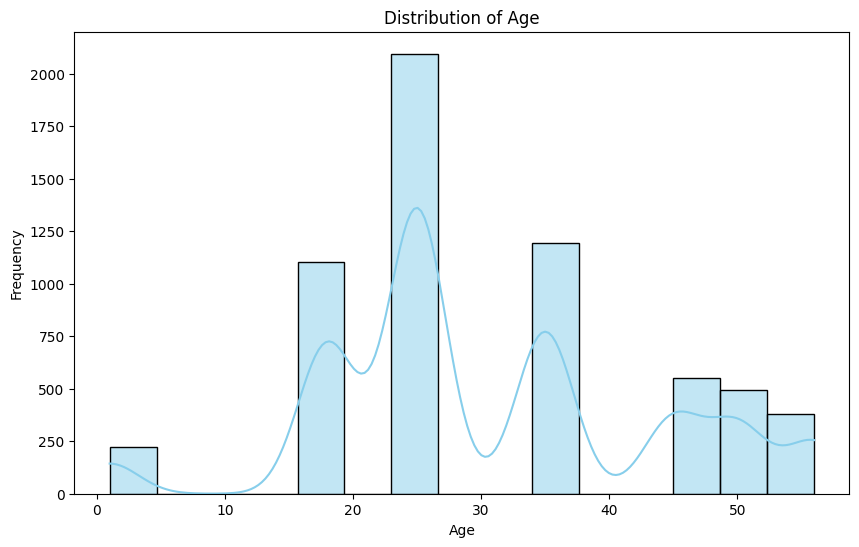

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data=users_data, x='Age', kde=True, bins=15, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()



Visualize the gender distribution


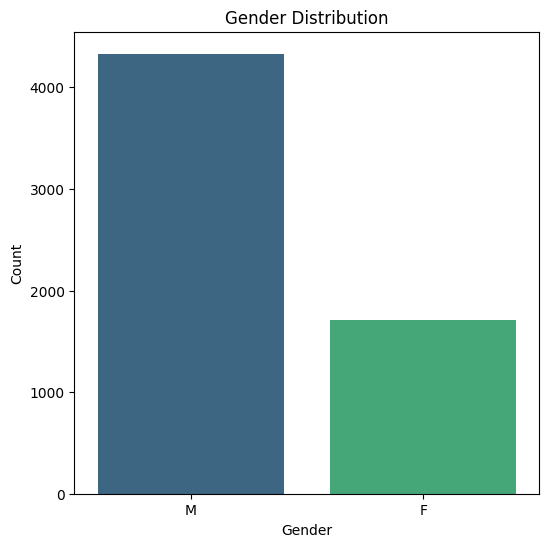

In [27]:
gender_counts = users_data['Gender'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='viridis')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

Visualize the occupation distribution


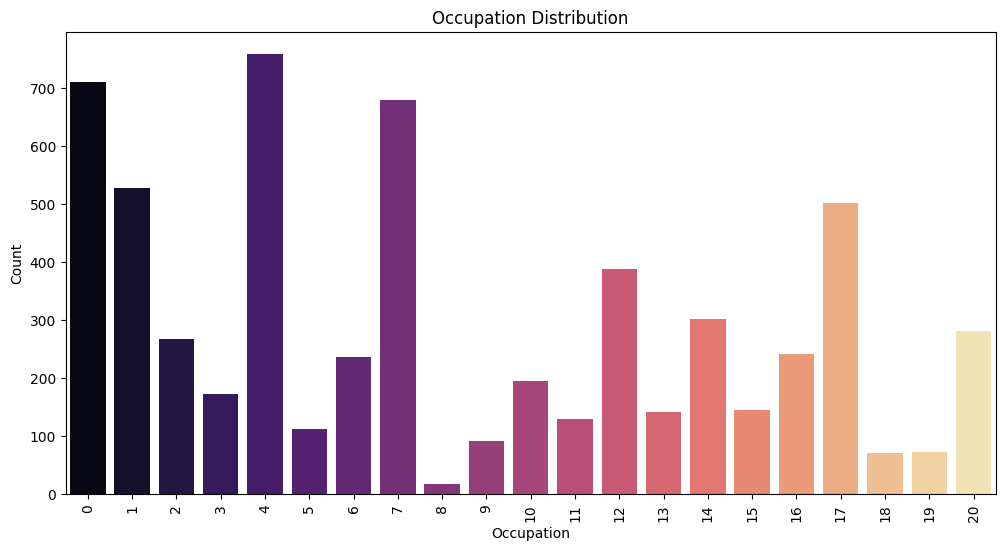

In [28]:
occupation_counts = users_data['Occupation'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette='magma')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.title('Occupation Distribution')
plt.xticks(rotation=90)
plt.show()

 **Initialize the LabelEncoder**
 *Convert the 'Gender' column to numerical values using LabelEncoder
 Note: LabelEncoder assigns unique numerical values to each unique category in the column
 This allows the model to interpret and process the categorical data*

In [29]:
label_encoder = LabelEncoder()
users_data['Gender'] = label_encoder.fit_transform(users_data['Gender'])

In [30]:
users_data = users_data.drop(['Zip-code'], axis = 1)

 Merging Datasets

In [31]:
merged_data = pd.merge(movies_data, ratings_data, on= 'MovieID')

Check Null Values 

In [32]:
null_values = merged_data.isnull().sum()
null_values

MovieID         0
Title           0
Genre           0
Title_Length    0
Year            0
UserID          0
Ratings         0
TimeStamp       0
dtype: int64

In [33]:
merged_data = pd.merge(users_data, merged_data, on= 'UserID')

In [34]:
merged_data

,UserID,Gender,Age,Occupation,MovieID,Title,Genre,Title_Length,Year,Ratings,TimeStamp
0,1,0,1,10,1,Toy Story,Animation|Children's|Comedy,16,1995,5,978824268
1,1,0,1,10,48,Pocahontas,Animation|Children's|Musical|Romance,17,1995,5,978824351
2,1,0,1,10,150,Apollo 13,Drama,16,1995,5,978301777
3,1,0,1,10,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Fantasy|Sci-Fi,41,1977,4,978300760
4,1,0,1,10,527,Schindler's List,Drama|War,23,1993,5,978824195
...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1,25,6,3683,Blood Simple,Drama|Film-Noir,19,1984,4,960971696
1000205,6040,1,25,6,3703,Mad Max 2 (a.k.a. The Road Warrior),Action|Sci-Fi,42,1981,4,964828575
1000206,6040,1,25,6,3735,Serpico,Crime|Drama,14,1973,4,960971654
1000207,6040,1,25,6,3751,Chicken Run,Animation|Children's|Comedy,18,2000,4,964828782


In [35]:
import pandas as pd

# Extract unique genres
unique_genres = set()
for genres in merged_data['Genre']:
    unique_genres.update(genres.split('|'))



In [36]:
# Create a column for each genre and initialize with 0
for genre in unique_genres:
    merged_data[genre] = 0



Set 1 for corresponding genres



In [37]:
for i, genres in enumerate(merged_data['Genre']):
    for genre in genres.split('|'):
        merged_data.at[i, genre] = 1

Drop the original 'Genres' column

In [38]:
merged_data.drop('Genre', axis=1, inplace=True)

In [39]:
# Apply label encoding to the 'Title' column (if needed)
label_encoder = LabelEncoder()
merged_data['Title_Encoded'] = label_encoder.fit_transform(merged_data['Title'])

# Print the updated dataset
print(merged_data.head())

   UserID  Gender  Age  Occupation  MovieID  \
0       1       0    1          10        1   
1       1       0    1          10       48   
2       1       0    1          10      150   
3       1       0    1          10      260   
4       1       0    1          10      527   

                                 Title  Title_Length  Year  Ratings  \
0                           Toy Story             16  1995        5   
1                          Pocahontas             17  1995        5   
2                           Apollo 13             16  1995        5   
3  Star Wars: Episode IV - A New Hope             41  1977        4   
4                    Schindler's List             23  1993        5   

   TimeStamp  ...  Film-Noir  Comedy  Children's  Adventure  Mystery  Fantasy  \
0  978824268  ...          0       1           1          0        0        0   
1  978824351  ...          0       0           1          0        0        0   
2  978301777  ...          0       0           

Droping Irrelevent Columns

In [40]:
merged_data1 = merged_data.drop(['Title','UserID','Occupation','Title_Length','MovieID'], axis = 1)

Converting Object column to int

In [41]:
merged_data1['Year'] = merged_data1['Year'].astype(int)

 Sample 20% of the data


In [42]:
sample_size = merged_data1.sample(frac=0.2, random_state=42)

Split the data into features and target variable


In [43]:
X = sample_size.drop('Ratings', axis=1)
y = sample_size['Ratings']

Split the data into training and testing sets

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define the Gradient Boosting model


In [45]:
model = XGBRegressor()

Train and fit model

In [47]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Make predictions on the test set


In [48]:
y_pred = model.predict(X_test)

Calculate the Mean Squared Error

In [49]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.9848138216812377


Visualize the predicted vs. actual values

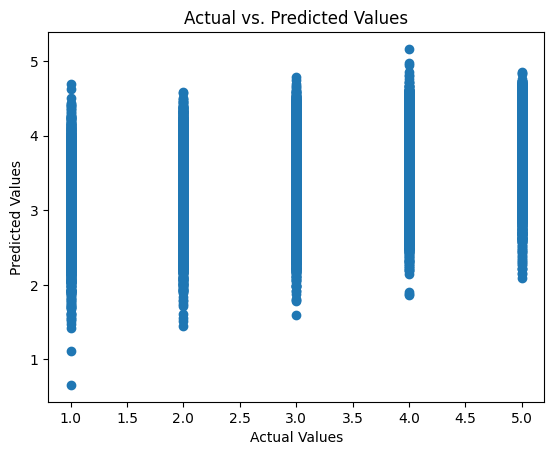

In [50]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

Visualize the feature importance

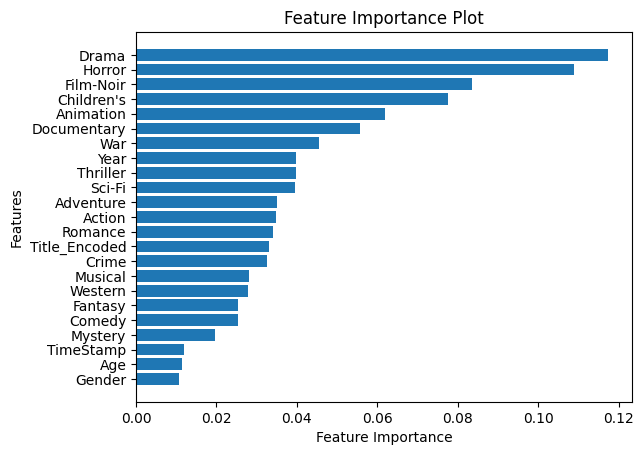

In [51]:
feature_importance = model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)

plt.barh(range(len(feature_names)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(feature_names)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

Testing the Model

In [64]:
test_data = pd.DataFrame({
    'Gender': [0, 1, 0],  # 0 for Female, 1 for Male
    'Age': [25, 35, 40],
    'Year': [2000, 2005, 2010],
    'TimeStamp': [123456789, 987654321, 543210987],
    'Action': [1, 1, 0],
    'Romance': [0, 1, 1],
    'Crime': [1, 0, 1],
    'Drama': [0, 1, 1],
    'Sci-Fi': [0, 0, 1],
    'Documentary': [0, 1, 0],
    'War': [0, 0, 1],
    'Thriller': [1, 1, 0],
    'Western': [0, 0, 1],
    'Film-Noir': [0, 0, 1],
    'Comedy': [1, 0, 1],
    "Children's": [0, 1, 0],
    'Adventure': [1, 1, 0],
    'Mystery': [1, 0, 1],
    'Fantasy': [0, 1, 0],
    'Animation': [0, 1, 0],
    'Horror': [1, 0, 0],
    'Musical': [1, 0, 0],
    'Title_Encoded': [100, 200, 300]
})

# Make predictions on the test data
predictions = model.predict(test_data)

# Print the predicted ratings
for rating in predictions:
    print("Predicted rating:", rating)


Predicted rating: 2.4177873
Predicted rating: 1.2139294
Predicted rating: 1.4212043
